# A Notebook for Data Plotting

## Imports

In [1]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.grid'] = True  # Turns on gridlines by default
plt.rcParams['grid.alpha'] = 0.9  # Sets the alpha (transparency)
plt.rcParams['grid.color'] = '#cccccc'  # Sets the grid color
plt.rcParams['grid.linestyle'] = '--'  # Sets the line style
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['hatch.linewidth'] = 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black"})
okabe_ito_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#000000']
sns.set_palette(okabe_ito_palette)
colors = okabe_ito_palette


In [3]:
# nice plot templates
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp

--2023-11-19 16:17:03--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine-dawn.mplstyle’

rose-pine-dawn.mpls 100%[===================>]  39,95K  --.-KB/s    in 0,003s  

2023-11-19 16:17:03 (12,2 MB/s) - ‘/tmp/rose-pine-dawn.mplstyle’ saved [40905/40905]



## Data Imports

In [4]:
stats_signif = 3
n_base_scenarios = 11
n_test_scenarios = 8
n_rule_scenarios = 32
num_timesteps = 300
result_path = "../results_selfish-learning/"
figures_path = "../results_selfish-learning/figures/"

In [5]:
baseline_dfs = [[] for _ in range(n_base_scenarios)]
for scenario in range(n_base_scenarios):
        for k in range(stats_signif):
            path = result_path + f"base/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                baseline_df = pd.read_csv(whole)
                baseline_dfs[scenario].append(baseline_df)


In [6]:
test_dfs = [[] for _ in range(n_test_scenarios)]
for scenario in range(n_test_scenarios):
    for k in range(stats_signif):
        path = result_path + f"test/scenario{scenario+1}/"
        filename = f"trial{k+1}.csv"
        if filename in os.listdir(path):
            whole = path + filename
            test_df = pd.read_csv(whole)
            test_dfs[scenario].append(test_df)

In [7]:
rules_dfs = [[] for _ in range(n_rule_scenarios)]
for scenario in range(n_rule_scenarios):
        for k in range(stats_signif):
            path = result_path + f"rule_trials/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                rules_df = pd.read_csv(whole)
                rules_dfs[scenario].append(rules_df)

In [8]:
rule_baseline = [[] for _ in range(n_rule_scenarios)]
for scenario in range(n_rule_scenarios):
        for k in range(stats_signif):
            path = result_path + f"rule_baseline/scenario{scenario+1}/"
            filename = f"trial{k+1}.csv"
            if filename in os.listdir(path):
                whole = path + filename
                rules_df = pd.read_csv(whole)
                rule_baseline[scenario].append(rules_df)

# Dataframes so far:
1. baseline_dfs
2. test_dfs
3. rules_dfs

In [9]:
settings_path = "../results_learning/settings.csv"
settings_names_path = "../results_learning/settings_names.csv"
settings_lambda_path = "../results_learning/settings_lambda.csv"
settings = pd.read_csv(settings_path)
settings_names = pd.read_csv(settings_names_path)
settings_lambda = pd.read_csv(settings_lambda_path)


In [10]:
all_rules = rules_dfs[0][0].columns.tolist()

# Basic Stats

In [13]:
from sklearn.preprocessing import MinMaxScaler

### Getting the set of active rules in regard to rule or role combination

In [25]:
PROHIBITIONS = {
  'obs["CUR_CELL_HAS_APPLE"] and obs["NUM_APPLES_AROUND"] < 3 -> !MOVE_ACTION': "Don't empty orchard",
  'obs["CUR_CELL_HAS_APPLE"] and obs["CUR_CELL_IS_FOREIGN_PROPERTY"] -> !MOVE_ACTION': "Don't steal",
}
OBLIGATION_CLEANER = {
    'obs["DIRT_FRACTION"] > 0.3 and obs["AGENT_LOOK"] == 1 -> obs["SINCE_AGENT_LAST_CLEANED"] == 0': "Cleaner should clean"
}
OBLIGATION_FARMER = {
    'obs["SINCE_AGENT_LAST_PAID"] > 30 and obs["AGENT_LOOK"] == 2 -> obs["SINCE_AGENT_LAST_PAID"] == 0': "Farmer should pay",
}
OBLIGATION_FREE = {
    'obs["DIRT_FRACTION"] > 0.45 and obs["AGENT_LOOK"] == 0 -> obs["SINCE_AGENT_LAST_CLEANED"] == 0': "Egalitarian should clean",
}
ACTIVE_RULES_PER_ROLE = [
    {},
    PROHIBITIONS | OBLIGATION_FREE,
    PROHIBITIONS | OBLIGATION_CLEANER,
    PROHIBITIONS,
    PROHIBITIONS | OBLIGATION_FREE | OBLIGATION_CLEANER,
    PROHIBITIONS | OBLIGATION_FREE,
    PROHIBITIONS | OBLIGATION_FARMER | OBLIGATION_CLEANER,
    PROHIBITIONS | OBLIGATION_FARMER | OBLIGATION_CLEANER | OBLIGATION_FREE
]
ALL_RULES_LIST = [
    {'obs["CUR_CELL_HAS_APPLE"] and obs["NUM_APPLES_AROUND"] < 3 -> !MOVE_ACTION': "Don't empty orchard",},
    {'obs["CUR_CELL_HAS_APPLE"] and obs["CUR_CELL_IS_FOREIGN_PROPERTY"] -> !MOVE_ACTION': "Don't steal"},
    OBLIGATION_CLEANER, OBLIGATION_FARMER, OBLIGATION_FREE
]

In [26]:
def get_active_rules(i: int, setting: str):
    """Returns a list of active rules in regard to the setting"""
    if setting == 'rules':
        return [rule.strip("'").strip(",").strip("'") for rule in settings_lambda.iloc[i, 3].strip('(').strip(')').split(', ')]
    elif setting == 'test':
        return ACTIVE_RULES_PER_ROLE[i]
    return

In [27]:
TEST_SETTING_NAME = [
    "Leaner",
    "Free + learner",
    "Cleaner + learner",
    "Farmer + learner",
    "Cleaner, free + learner",
    "Farmer, free + learner",
    "Cleaner, farmer + learner",
    "Cleaner, farmer, free + learner",
]

In [28]:
X_LABELS_RULE_SETS = ["0",
                      "1.1*", "1.2*", "1.3", "1.4", "1.5",
                      "2.1*", "2.2*", "2.3*", "2.4*", "2.5*", "2.6*", "2.7'", "2.8", "2.9", "2.10",
                      "3.1*", "3.2*", "3.3*", "3.4*", "3.5*", "3.6*", "3.7*", "3.8*", "3.9*", "3.10",
                      "4.1*", "4.2*", "4.3*", "4.4*", "4.5",
                      "5*"]

In [29]:
X_LABELS_ROLE_SETS = ["L", 
                      "CL", "FL", "EL",
                      "CFL", "CEL", "FEL",
                      "CFEL"
]

In [30]:
X_LABELS_ROLE_BASELINE = ["C", "F", "E", 
                          "CF", "CE", "FE", "EE",
                          "CFE", "CEE", "FEE",
                          "CFEE"
]

In [31]:
def get_x_labels(num_settings: int):
    if num_settings <= 8:
        return X_LABELS_ROLE_SETS
    elif num_settings <= 11:
        return X_LABELS_ROLE_BASELINE
    return X_LABELS_RULE_SETS

In [32]:
def get_setting_name(i: int, setting_str: str) -> str:
    """Returns a printable setting of roles for legend."""
    if setting_str == 'test':
        return TEST_SETTING_NAME[i]
    else:
        return settings_names.iloc[i, 3].split(", ")

In [33]:
ALL_RULES_LIST = PROHIBITIONS | OBLIGATION_FARMER | OBLIGATION_CLEANER | OBLIGATION_FREE

In [34]:
# List of all rules
ALL_RULES = PROHIBITIONS | OBLIGATION_FARMER | OBLIGATION_CLEANER | OBLIGATION_FREE

## Declarations for Data of Interest (What Timesteps, What Percentages)

In [35]:
target_percentages = [0.2, 0.4, 0.6, 0.8, 0.99]
target_timesteps = [0, 75, 150, 225, 299]
num_timesteps = len(target_timesteps)
num_trials = 13

## Functions for Extracting Data of Interest

In [36]:
LOGICALLY_CONSISTENT_RULES = [
    'obs["CUR_CELL_HAS_APPLE"] and obs["NUM_APPLES_AROUND"] < 1 -> !MOVE_ACTION',
    'obs["CUR_CELL_HAS_APPLE"] and obs["NUM_APPLES_AROUND"] < 2 -> !MOVE_ACTION',
    'obs["DIRT_FRACTION"] > 0.3 and obs["AGENT_LOOK"] == 0 -> obs["SINCE_AGENT_LAST_CLEANED"] == 0',
    'obs["DIRT_FRACTION"] > 0.35 and obs["AGENT_LOOK"] == 0 -> obs["SINCE_AGENT_LAST_CLEANED"] == 0',
    'obs["DIRT_FRACTION"] > 0.4 and obs["AGENT_LOOK"] == 0 -> obs["SINCE_AGENT_LAST_CLEANED"] == 0',
    'obs["SINCE_AGENT_LAST_PAID"] > 30 and obs["AGENT_LOOK"] == 2 -> obs["SINCE_AGENT_LAST_PAID"] == 0',
    'obs["SINCE_AGENT_LAST_PAID"] > 25 and obs["AGENT_LOOK"] == 2 -> obs["SINCE_AGENT_LAST_PAID"] == 0',
    'obs["SINCE_AGENT_LAST_PAID"] > 20 and obs["AGENT_LOOK"] == 2 -> obs["SINCE_AGENT_LAST_PAID"] == 0',
    'obs["SINCE_AGENT_LAST_PAID"] > 15 and obs["AGENT_LOOK"] == 2 -> obs["SINCE_AGENT_LAST_PAID"] == 0',
    'obs["SINCE_AGENT_LAST_PAID"] > 10 and obs["AGENT_LOOK"] == 2 -> obs["SINCE_AGENT_LAST_PAID"] == 0',
]

In [37]:
MOST_FREQUENT_FALSE_POSITIVES = { 
    'obs["ORIENTATION"] == 3 -> !MOVE_ACTION': "If you're facing West, don't move",
    'obs["ORIENTATION"] == 1 -> !MOVE_ACTION': "If you're facing East, don't move",
    'obs["ORIENTATION"] == 0 -> !EAT_ACTION': "If you're facing North, don't eat",
    'obs["ORIENTATION"] == 0 -> !MOVE_ACTION': "If you're facing North, don't move",
    'obs["CUR_CELL_HAS_APPLE"] -> !EAT_ACTION': "If you're standing on an apple cell, don't eat",
    'obs["POSITION"][0] == obs["POSITION"][1] -> !MOVE_ACTION': "If you're x and y coordinates are equal, don't move"
    }

In [38]:
FALSE_POSITIVES = [rule for rule in rules_dfs[0][0][9:] if "obs" in rule and rule not in ALL_RULES]

In [39]:
def extract_tp_and_fn(df_list: list, num_setting: int, percentage: float, timestep: int, setting_str: str):
    tp_active_vals = []
    fn_active_vals = []
    tp_nonactive_vals = []
    fn_nonactive_vals = []

    for trial in range(stats_signif):
        tp_active = 0
        fn_active = 0
        tp_nonactive = 0
        fn_nonactive = 0
        
        df = df_list[num_setting][trial]
        active_rules = get_active_rules(num_setting, setting_str)
        if "" in active_rules:
            active_rules.remove("")

        for rule in active_rules:
            if df.loc[timestep, rule] >= percentage:
                tp_active += 1
            else:
                fn_active += 1
                
        for column in df.iloc[:, 10:].columns:
            if column not in LOGICALLY_CONSISTENT_RULES:
                if column not in active_rules:
                    if df.loc[timestep, column] < percentage:
                        tp_nonactive += 1
                    else:
                        fn_nonactive += 1

        tp_active_vals.append(tp_active)
        fn_active_vals.append(fn_active)
        tp_nonactive_vals.append(tp_nonactive)
        fn_nonactive_vals.append(fn_nonactive)

    std_tp_active = np.std(tp_active_vals, ddof=1)
    std_fn_active = np.std(fn_active_vals, ddof=1)
    std_tp_nonactive = np.std(tp_nonactive_vals, ddof=1)
    std_fn_nonactive = np.std(fn_nonactive_vals, ddof=1)

    return sum(tp_active_vals), sum(fn_active_vals), sum(tp_nonactive_vals), sum(fn_nonactive_vals), std_tp_active, std_fn_active, std_tp_nonactive, std_fn_nonactive


In [43]:
def extract_timesteps(input_dfs: pd.DataFrame, num_settings: int, setting_str: str,
                      target_percentages: list, target_timesteps: list):
    """
Returns list of dicts with each dict representing one run with extracted posteriors.

        Dict Values:
            Setting:                index of setting (1 to 32 for rule, 1 to 8 for role combinations)
            Trial:                  index of trial (1 of 13)
            Dsicrete Timesteps:     list of timesteos x where x is ts where x > posterios y
            Discrete Percentages:   list of posterios for timesteps of interest
            All Values:             list of all posterios
            Num Active Rules:       number of active rules for this setting 
    """
    results = []
    for i in range(num_settings):
        for j in range(stats_signif):
            # Load the corresponding dataframe
            df = input_dfs[i][j]

            active_rules = get_active_rules(i, setting_str)
            if '' in active_rules:
                active_rules.remove('')
                
            # Extract only the active rules from the dataframe
            df_active = df[active_rules]
            num_active = len(active_rules)

            # Calculate the timesteps where the agent has learned 50%, 80%, and 100% of the rules
            learned = []
            for row in df_active.itertuples():
                if not len(df_active.columns) == 0:
                    learned.append(sum(row[1:]) / len(df_active.columns))
                else:
                    learned.append(sum(row[1:]))

            timesteps = []
            for target in target_percentages:
                flag = False
                for idx, percent in enumerate(learned):
                    if percent >= target:
                        timesteps.append(idx)
                        flag = True
                        break
                if flag == False:
                    timesteps.append(np.nan)

            # Calculate the percentage of rules learned at timesteps 10, 30, and 50
            percentages = []
            for target in target_timesteps:
                if not len(df_active.columns) == 0:
                    percentages.append(sum(df_active.iloc[target]) / len(df_active.columns))

                else:
                    percentages.append(sum(df_active.iloc[target]))

            # Store the results for this setting and trial
            results.append({'setting': i, 'trial': j, 'discrete_timesteps': timesteps, 
                            'discrete_percentages': percentages, 'all_values': learned,
                            'num_active_rules': num_active})

    return results

In [44]:
def extract_active_rules(input_dfs: pd.DataFrame, num_settings: int, rules: list, setting_str: str):
    """
    Returns list of dicts with each dict representing one run with extracted rule posteriors.

        Dict Values:
            Setting:            index of setting (1 to 32 for rule, 1 to 8 for role combinations)
            Trial:              index of trial (1 of 13)
            Rule:               rule for this setting
            All Values:         list of all posteriors for this rule
    """
    results = []
    for i in range(num_settings):
        for j in range(stats_signif):
            # Load the corresponding dataframe
            df = input_dfs[i][j]

            active_rules = get_active_rules(i, setting_str)
            if "" in active_rules:
                active_rules.remove("")

            for idx, rule in enumerate(rules):
                # Extract only the active rules from the dataframe
                df_active = df[[rule]]

                learned = []
                for row in df_active.itertuples():
                    if not rule in active_rules:
                        learned.append(np.nan)
                    else:
                        if not len(df_active.columns) == 0:
                            learned.append(sum(row[1:]) / len(df_active.columns))
                        else:
                            learned.append(sum(row[1:]))

                # Step 4: Store the results for this setting and trial
                results.append({'setting': i, 'trial': j, 'rule': rule, 'rule_idx': idx, 'all_values': learned})

    return results

In [45]:
def extract_all_rules(input_dfs: pd.DataFrame, num_settings: int, rules: list):
    """
    Returns list of dicts with each dict representing one run with extracted rule posteriors.

        Dict Values:
            Setting:            index of setting (1 to 32 for rule, 1 to 8 for role combinations)
            Trial:              index of trial (1 of 13)
            Rule:               rule for this setting
            All Values:         list of all posteriors for this rule
    """
    results = []
    for i in range(num_settings):
        for j in range(stats_signif):
            # Load the corresponding dataframe
            df = input_dfs[i][j]

            for idx, rule in enumerate(rules):
                # Extract only the active rules from the dataframe
                df_active = df[[rule]]

                learned = []
                for row in df_active.itertuples():
                    learned.append(sum(row[1:]))

                # Step 4: Store the results for this setting and trial
                results.append({'setting': i, 'trial': j, 'rule': rule, 'rule_idx': idx, 'all_values': learned})

    return results

## Function for Calculating F1


In [46]:
def get_f1_score(tp, fn, tn, fp):
    # Avoid division by zero in precision calculation
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
        
    # Avoid division by zero in recall calculation
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
        
    # Avoid division by zero in F1 Score calculation
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        
    return precision, recall, f1_score

    

In [47]:
def get_f1_per_setting_per_specific_ts(timesteps: list, df_list: list, settings_str: str):
    num_settings = len(df_list)

    precision_vals = [[] for _ in range(num_settings)]
    recall_vals = [[] for _ in range(num_settings)]
    f1_vals = [[] for _ in range(num_settings)]
    
    # Lists to hold standard deviation values
    std_precision_vals = [[] for _ in range(num_settings)]
    std_recall_vals = [[] for _ in range(num_settings)]
    std_f1_vals = [[] for _ in range(num_settings)]

    for timestep in timesteps:
        for setting in range(num_settings):
            tp, fn, tn, fp, std_tp, std_fn, std_tn, std_fp = extract_tp_and_fn(df_list=df_list, 
                                            percentage=0.95,
                                            num_setting=setting, 
                                            timestep=timestep, 
                                            setting_str=settings_str)

            precision, recall, f1_score = get_f1_score(tp, fn, tn, fp)
            precision, recall, f1_score = round(precision, 3), round(recall, 3), round(f1_score, 3)

            # Calculate standard deviation for precision, recall, and f1
            std_precision = round(std_tp / (std_tp + std_fp + 1e-10), 3)
            std_recall = round(std_tp / (std_tp + std_fn + 1e-10), 3)
            std_f1 = round(2 * ((precision * std_recall + std_precision * recall) / 
                       (precision + recall + 1e-10)), 3)

            precision_vals[setting].append(precision)
            recall_vals[setting].append(recall)
            f1_vals[setting].append(f1_score)
            
            # Add the computed standard deviations to their respective lists
            std_precision_vals[setting].append(std_precision)
            std_recall_vals[setting].append(std_recall)
            std_f1_vals[setting].append(std_f1)

    return precision_vals, recall_vals, f1_vals, std_precision_vals, std_recall_vals, std_f1_vals


In [49]:
def get_f1_across_timesteps_and_percentages(percentages: list, timesteps: list, df_list: list, settings_str: str):
    """Calculates F1 score across all settings for a combination as well as per setting"""
    tp_total, fn_total, tn_total, fp_total = 0, 0, 0, 0
    num_settings = len(df_list)

    precision_vals = []
    recall_vals = []
    f1_vals = []

    for setting in range(num_settings):
        tp_intermediate, fn_intermediate, tn_intermediate, fp_intermediate = 0, 0, 0, 0
            
        for timestep in timesteps:
            for percentage in percentages:
                tp, fn, tn, fp, std_tp, std_fn, std_tn, std_fp = extract_tp_and_fn(df_list=df_list, 
                                                num_setting=setting, 
                                                percentage=percentage, 
                                                timestep=timestep, 
                                                setting_str=settings_str)

                tp_total += tp
                fn_total += fn
                tn_total += tn
                fp_total += fp

                tp_intermediate += tp
                fn_intermediate += fn
                tn_intermediate += tn
                fp_intermediate += fp
        
        num_combinations_intermediate = len(percentages) * len(timesteps) * stats_signif
        intermediate_avg_tp = tp_intermediate / num_combinations_intermediate
        intermediate_avg_fn = fn_intermediate / num_combinations_intermediate
        intermediate_avg_tn = tn_intermediate / num_combinations_intermediate
        intermediate_avg_fp = fp_intermediate / num_combinations_intermediate

        precision, recall, f1_score = get_f1_score(intermediate_avg_tp, intermediate_avg_fn, intermediate_avg_tn, intermediate_avg_fp)
        precision, recall, f1_score = round(precision, 3), round(recall, 3), round(f1_score, 3)

        precision_vals.append(precision)
        recall_vals.append(recall)
        f1_vals.append(f1_score)

        # Print the results
        #print(f'Setting {setting+1}:\tPre: {precision}, Rec: {recall}, F1: {f1_score}')
        """print(f'Active rules TP: {intermediate_avg_tp}')
        print(f'Non-active rules TP: {intermediate_avg_fn}')
        print(f'Active rules FN: {intermediate_avg_tn}')
        print(f'Non-active rules FN: {intermediate_avg_fp}')"""
            
    num_combinations = len(percentages) * len(timesteps) * num_trials * num_settings
    total_avg_tp = tp_total / num_combinations
    total_avg_fn = fn_total / num_combinations
    total_avg_tn = tn_total / num_combinations
    total_avg_fp = fp_total / num_combinations

    total_precision, total_recall, total_f1_score = get_f1_score(total_avg_tp, total_avg_fn, total_avg_tn, total_avg_fp)
    total_precision, total_recall, total_f1_score = round(total_precision, 3), round(total_recall, 3), round(total_f1_score, 3)

    # Print the results
    print(f'Across all settings, timesteps, and percentages:\tPre: {total_precision}, Rec: {total_recall}, F1: {total_f1_score}')
    """print(f'Active rules TP: {total_avg_tp}')
    print(f'Non-active rules TP: {total_avg_fn}')
    print(f'Active rules FN: {total_avg_tn}')
    print(f'Non-active rules FN: {total_avg_fp}')"""

    return precision_vals, recall_vals, f1_vals

## Functions for Plotting

In [55]:
def plot_all_timesteps_per_percentage(all_values: list, 
                                      setting_str: str, 
                                      name: str) -> None:
    """Plots continuous posteriors for each timestep, grouped by setting."""

    #with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
    plt.figure(figsize=(12,6))
    for setting in range(len(all_values)):
        setting_timesteps = np.array(all_values[setting])
        mean_timesteps = np.nanmean(setting_timesteps, axis=0)
        setting_name = get_setting_name(setting, setting_str)
        plt.errorbar([*range(len(mean_timesteps))], mean_timesteps, label=f'{setting_name}', linewidth=2.5)

    plt.legend()
    plt.xlabel('Timestep')
    plt.ylabel('Percentage')
    plt.ylim([0, 1.1])
    plt.title('Percentage of Learned Rules per Timestep, by Setting')
    plt.show()

In [56]:
def plot_single_rule_learning(rules: dict, 
                              all_values: list, 
                              name: str,
                              fp: list = None,) -> None:
    """Plots posterior of rule at certain timestep, grouped by rule."""

    #with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
    plt.figure(figsize=(12,6))
    rule_handle = []
    for idx, rule in enumerate(rules.keys()):
        rule_name = rules[rule]

        labels = [f'P1:\t\t{rule_name}', 
                  f'P2:\t\t{rule_name}', 
                  f'O1:\t\t{rule_name}', 
                  f'O2:\t\t{rule_name}', 
                  f'O3:\t\t{rule_name}']

        averaged_data = np.nanmean(all_values[idx], axis=0)
        sem_data = np.nanstd(all_values[idx], axis=0) / np.sqrt(len(all_values[idx]))

        if len(rules.keys()) == 4:
            averaged_data = averaged_data * 1.66

        width = 2 if not "True" in rule_name else 3
        rule_data, = plt.plot(averaged_data, label=labels[idx], linewidth=3, linestyle="-", c=colors[idx])
        rule_handle.append(rule_data)
        plt.fill_between(x=range(300),
                 y1=averaged_data - sem_data, 
                 y2=averaged_data + sem_data, 
                 alpha=0.1, 
                 color=colors[idx])
        
    first_legend = plt.legend(handles=rule_handle, loc=(0.52, 0.33), frameon=False, columnspacing=2)
    plt.gca().add_artist(first_legend)
        
    if fp != None:
        false_pos_mean = np.nanmean(fp, axis=(0, 1, 2))
        false_pos_sem = np.nanstd(fp, axis=(0, 1, 2)) / np.sqrt(len(fp))

        fp_data, = plt.plot(false_pos_mean, label='False Postives', linewidth=3, linestyle="-", c='black')
        plt.fill_between(range(300), false_pos_mean - false_pos_sem, false_pos_mean + false_pos_sem, alpha=0.1, color='black')

    plt.axhline(y=0.95, color='r', linestyle='--')
    plt.text(4, 0.89, 'Compliance Threshold', color='black', fontsize=18)

    sec_legend = plt.legend(handles=[fp_data], loc='lower right', frameon=False, columnspacing=2)
    plt.gca().add_artist(sec_legend)

    plt.xlabel('Time Step')
    plt.ylabel('Posterior Belief')
    
    yticks = list(plt.yticks()[0])  # Get the current y-ticks
    if 0.95 not in yticks:
        yticks.append(0.95)
        yticks = sorted(yticks)[2:]

    plt.yticks(yticks) 
    plt.ylim([0, 1.01])
    plt.xlim([0, 300])
    #plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    #plt.title('Percentage of Learned Rules per Timestep, by Rule')
    plt.savefig(figures_path+name+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

## A.1 Ratio of Learned Rules — Rule Combinations

In [66]:
num_settings = 32
setting_str = 'rules' # 'rules' or 'test'
df_list = rules_dfs

timestep_results = extract_timesteps(input_dfs=df_list, num_settings=num_settings, setting_str=setting_str,
                target_percentages=target_percentages, target_timesteps=target_timesteps)

single_rule_results = extract_active_rules(input_dfs=df_list, num_settings=num_settings, rules=ALL_RULES, setting_str=setting_str)

percentages_all = [[[0 for _ in range(num_timesteps)] for _ in range(stats_signif)] for _ in range(num_settings)]
timesteps_all = [[[0 for _ in range(num_timesteps)] for _ in range(stats_signif)] for _ in range(num_settings)]
continuous_timesteps = [[[] for _ in range(stats_signif)] for _ in range(num_settings)]
continuous_rules = [[[0 for _ in range(stats_signif)] for _ in range(num_settings)] for _ in range(len(ALL_RULES))]

for result in timestep_results:
    setting = result['setting']
    trial = result['trial']
    timesteps = result['discrete_timesteps']
    percentages = result['discrete_percentages']
    all_values = result['all_values']
    continuous_timesteps[setting][trial] = all_values
    
    for i in range(num_timesteps):
        timestep = i
        timesteps_all[setting][trial][timestep] = timesteps[i]
        percentages_all[setting][trial][timestep] = percentages[i]

continuous_timesteps_0 = continuous_timesteps[0]
continuous_timesteps_1 = continuous_timesteps[1:6]
continuous_timesteps_2 = continuous_timesteps[6:15]
continuous_timesteps_3 = continuous_timesteps[15:26]
continuous_timesteps_4 = continuous_timesteps[26:31]
continuous_timesteps_5 = continuous_timesteps[31]

for result in single_rule_results:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules[rule_idx][setting][trial] = all_values


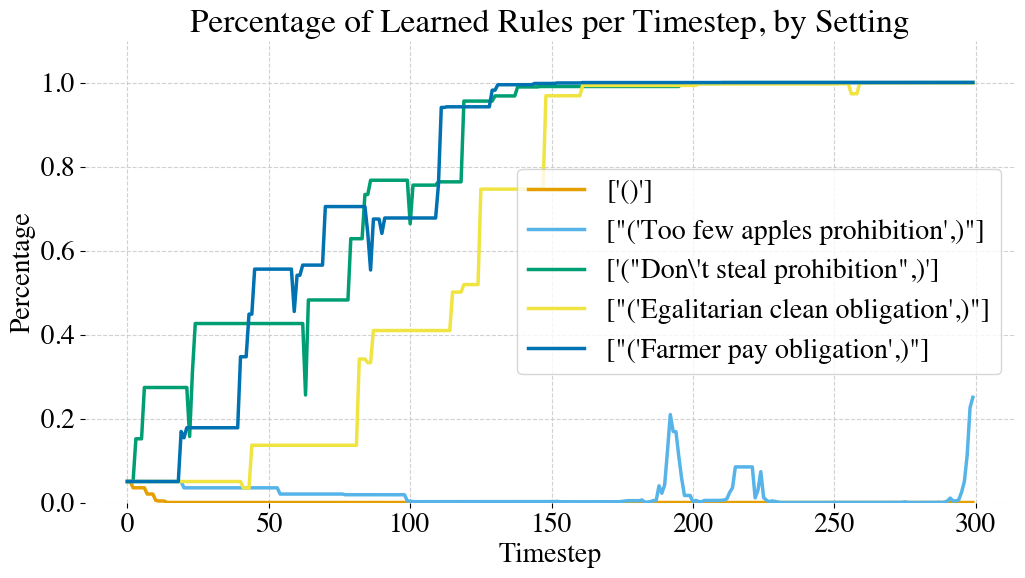

In [70]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_1, setting_str=setting_str, name="percentage_learner_per_setting_rules_1"
)

## B.1 Ratio of Learned Rules — Per Rule, Rule Combinations

In [75]:
single_rule_results_fp = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=FALSE_POSITIVES)
continuous_rules_fp = [[[0 for _ in range(stats_signif)] for _ in range(num_settings)] for _ in range(len(FALSE_POSITIVES))]

for result in single_rule_results_fp:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_fp[rule_idx][setting][trial] = all_values

In [76]:
continuous_rules_31 = []
for rule_idx, rule in enumerate(continuous_rules):
    for setting_idx, setting in enumerate(rule):
        if setting_idx == 31:
            continuous_rules_31.append(continuous_rules[rule_idx][setting_idx])

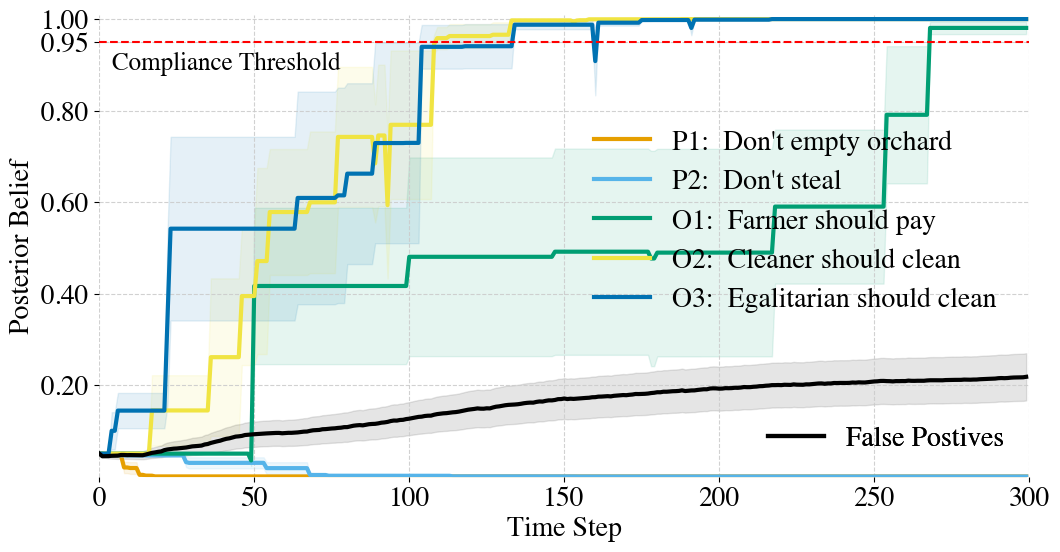

In [77]:
plot_single_rule_learning(
    rules=ALL_RULES, all_values=continuous_rules_31, fp=continuous_rules_fp, name="avg_rule_per_timestep_rules"
)

## E.1 Plot F1 Scores for all Combinations

### -- Per Setting Across Timesteps and Posteriors

In [215]:
precisions, recalls, f1s = get_f1_across_timesteps_and_percentages(percentages=target_percentages, 
                                        timesteps=target_timesteps, 
                                        df_list=df_list, 
                                        settings_str=setting_str)

Across all settings, timesteps, and percentages:	Pre: 0.165, Rec: 0.571, F1: 0.256


In [156]:
rules_dfs_slices = [[0, 1], [1, 6], [6, 16], [16, 26], [26, 31], [31, 32]]

In [157]:
precision_vals, recall_vals, f1_vals, std_precision_vals, std_recall_vals, std_f1_vals = get_f1_per_setting_per_specific_ts(timesteps=target_timesteps, 
                                        df_list=df_list, 
                                        settings_str=setting_str)

In [158]:
def compute_averages_for_slices(precision_vals, recall_vals, std_precision_vals, std_recall_vals):
    averages = []
    std_averages = []
    
    for _, (start, end) in enumerate(rules_dfs_slices):
        num_timesteps = len(precision_vals[0])
        setting_averages = {'precision': [0]*num_timesteps, 'recall': [0]*num_timesteps}
        setting_std = {'precision': [0]*num_timesteps, 'recall': [0]*num_timesteps}
        
        # Calculate averages and standard deviations
        for timestep_idx in range(num_timesteps):
            for setting_idx in range(start, end, 1):
                setting_averages['precision'][timestep_idx] += precision_vals[setting_idx][timestep_idx]
                setting_averages['recall'][timestep_idx] += recall_vals[setting_idx][timestep_idx]
                setting_std['precision'][timestep_idx] += std_precision_vals[setting_idx][timestep_idx]
                setting_std['recall'][timestep_idx] += std_recall_vals[setting_idx][timestep_idx]
                
            setting_averages['precision'][timestep_idx] /= (end-start)
            setting_averages['recall'][timestep_idx] /= (end-start)
            setting_std['precision'][timestep_idx] /= (end-start)
            setting_std['recall'][timestep_idx] /= (end-start)
        
        averages.append(setting_averages)
        std_averages.append(setting_std)
    
    return averages, std_averages


In [159]:
averages = compute_averages_for_slices(precision_vals, recall_vals)

TypeError: compute_averages_for_slices() missing 2 required positional arguments: 'std_precision_vals' and 'std_recall_vals'

In [160]:
def generate_latex_table(averages, std_averages):
    num_timesteps = len(averages[0]['precision'])
    
    latex_str = "\\begin{table}[ht]\n"
    latex_str += "\\centering\n"
    
    timestep_labels = ["0%", "25%", "50%", "75%", "100%", "Std. Dev."]  # Added a label for the std. dev. column

    latex_str += "\\begin{tabular}{|l|" + "c|" * (num_timesteps + 1) + "}\n"
    latex_str += "\\hline\n"
    latex_str += "Number of Rules & " + " & ".join(timestep_labels[:num_timesteps+1]) + " \\\\\n"
    latex_str += "\\hline\n"
    
    # Compute column average standard deviations
    column_avg_std_precision = [sum([setting_std['precision'][timestep_idx] for setting_std in std_averages]) / len(std_averages) for timestep_idx in range(num_timesteps)]
    column_avg_std_recall = [sum([setting_std['recall'][timestep_idx] for setting_std in std_averages]) / len(std_averages) for timestep_idx in range(num_timesteps)]

    for setting_idx, (setting_averages, setting_std) in enumerate(zip(averages, std_averages)):
        precision_values = [f"{setting_averages['precision'][timestep_idx]:.2f}" for timestep_idx in range(num_timesteps)]
        recall_values = [f"{setting_averages['recall'][timestep_idx]:.2f}" for timestep_idx in range(num_timesteps)]
        
        # Compute row average standard deviations
        row_avg_std_precision = sum(setting_std['precision']) / num_timesteps
        row_avg_std_recall = sum(setting_std['recall']) / num_timesteps

        row_values = [f"{p}/{r}" for p, r in zip(precision_values, recall_values)]
        row_values.append(f"{row_avg_std_precision:.2f}/{row_avg_std_recall:.2f}")  # Add row average std. dev. value
        latex_str += f"{setting_idx} & " + " & ".join(row_values) + " \\\\\n"
        
        latex_str += "\\hline\n"

    # Append the column average std. devs. at the bottom
    column_values = [f"{p:.2f}/{r:.2f}" for p, r in zip(column_avg_std_precision, column_avg_std_recall)]
    overall_avg_std_precision = sum(column_avg_std_precision) / num_timesteps
    overall_avg_std_recall = sum(column_avg_std_recall) / num_timesteps
    column_values.append(f"{overall_avg_std_precision:.2f}/{overall_avg_std_recall:.2f}")
    latex_str += f"Std. Dev. & " + " & ".join(column_values) + " \\\\\n"

    latex_str += "\\hline\n"
    latex_str += "\\end{tabular}\\\\\n"
    latex_str += "\\end{table}"
    
    return latex_str


In [161]:
averages, std_averages = compute_averages_for_slices(precision_vals, recall_vals, std_precision_vals, std_recall_vals)
latex_avg = generate_latex_table(averages, std_averages)
print(latex_avg)


\begin{table}[ht]
\centering
\begin{tabular}{|l|c|c|c|c|c|c|}
\hline
Number of Rules & 0% & 25% & 50% & 75% & 100% & Std. Dev. \\
\hline
0 & 0.00/0.00 & 0.00/0.00 & 0.00/0.00 & 0.00/0.00 & 0.00/0.00 & 0.00/0.00 \\
\hline
1 & 0.00/0.00 & 0.15/0.09 & 0.08/0.40 & 0.06/0.54 & 0.06/0.57 & 0.10/0.36 \\
\hline
2 & 0.00/0.00 & 0.19/0.27 & 0.14/0.59 & 0.13/0.76 & 0.12/0.82 & 0.11/0.35 \\
\hline
3 & 0.00/0.00 & 0.24/0.37 & 0.21/0.63 & 0.18/0.77 & 0.18/0.83 & 0.13/0.40 \\
\hline
4 & 0.00/0.00 & 0.35/0.36 & 0.28/0.67 & 0.24/0.77 & 0.22/0.83 & 0.14/0.38 \\
\hline
5 & 0.00/0.00 & 0.47/0.25 & 0.43/0.57 & 0.34/0.79 & 0.32/0.83 & 0.17/0.40 \\
\hline
Std. Dev. & 0.00/0.00 & 0.19/0.38 & 0.15/0.42 & 0.11/0.40 & 0.09/0.38 & 0.11/0.32 \\
\hline
\end{tabular}\\
\end{table}


In [162]:
generate_latex_table(precisions, recalls, f1s)

NameError: name 'precisions' is not defined

Reward Per Learned Rules — Rule Combinations

In [164]:
rules_dfs_slices = [[0, 1], [1, 6], [6, 16], [16, 26], [26, 31], [31, 32]]
one_rule_slices = [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]
two_rules_slices = [[6, 7], [7, 8], [8, 9], [9, 10], [10, 11], 
                    [11, 12], [12, 13], [13, 14], [14, 15], [15, 16]]
three_rules_slices = [[16, 17], [17, 18], [18, 19], [19, 20], [20, 21], 
                      [21, 22], [22, 23], [23, 24], [24, 25], [25, 26]]
four_rule_slices = [[26, 27], [27, 28], [28, 29], [29, 30], [30, 31]]

In [165]:
labels_one_rule = ["P1", "P2", "O1", "O2", "O3"]
labels_two_rules = ["P1, P2", "P1, O1", "P1, O2", "P1, O3", "P2, O1", "P2, O2", "P2, O3", "O1, O2", "O1, O3", "O2, O3"]
labels_three_rules = ["P1, P2, O1", "P1, P2, O2", "P1, P2, O3", "P1, O1, O2", "P1, O1, O3", "P1, O2, O3", "P2, O1, O2", "P2, O1, O3", "P2, O2, O3", "O1, O2, O3"]
labels_four_rules = ["P1, P2, O1, O2", "P1, P2, O1, O3", "P1, P2, O2, O3", "P1, O1, O2, O3", "P2, O1, O2, O3"]



In [166]:
def get_collective_rewards(df_list: list):
    collective_rewards = []
    for setting in df_list: 
        setting_rewards = []
        for trial in setting: 
            collective_rewards_per_timestep = trial.iloc[:, 1:5] 
            rowwise_sum = collective_rewards_per_timestep.sum(axis=1)
            setting_rewards.append(rowwise_sum.tolist())
        collective_rewards.append(setting_rewards)
    return collective_rewards

In [167]:
def get_learner_rewards(df_list: list):
    learner_rewards = []
    for setting in df_list: 
        setting_rewards = []
        for trial in setting: 
            learner_rewards_per_timestep = trial.iloc[:, 4] 
            setting_rewards.append(learner_rewards_per_timestep)
        learner_rewards.append(setting_rewards)
    return learner_rewards


In [168]:
plt.figure(figsize=(12,6))
learner_colors = sns.diverging_palette(250, 30, l=65, center="dark", n=6)

def plot_reward(rules_dfs_slices, func=get_learner_rewards, name="learner_rewards", legend="Number of Active Norms", labels=[0, 1, 2, 3, 4, 5]):
    # Iterating over your slices and plotting each one on the same figure
    for idx, (i, j) in enumerate(rules_dfs_slices):
        rewards = func(rules_dfs[i:j])
        
        # Here, assuming each setting has the same number of timesteps
        num_timesteps = len(rewards[0][0]) if rewards else 0
        
        # Initialize arrays to hold cumulative mean and std deviation values for each timestep
        cumulative_mean_learner_rewards = np.zeros(num_timesteps)
        cumulative_std_dev_learner_rewards = np.zeros(num_timesteps)
        
        for setting_rewards in rewards:  # setting_rewards is a 2D array: [trials x timesteps]
            setting_rewards_array = np.array(setting_rewards)
            
            # Calculate cumulative sum of rewards at each time step
            cumulative_rewards_at_each_timestep = np.cumsum(setting_rewards_array, axis=1)
            
            # Calculate mean and std deviation of the cumulative sum at each time step
            mean_rewards = cumulative_rewards_at_each_timestep.mean(axis=0)
            std_dev_rewards = cumulative_rewards_at_each_timestep.std(axis=0)
            
            # Add the mean and std deviation to the cumulative arrays
            cumulative_mean_learner_rewards += mean_rewards
            cumulative_std_dev_learner_rewards += std_dev_rewards
        
        # Divide by the number of settings to get the average
        cumulative_mean_learner_rewards /= len(rewards) 
        cumulative_std_dev_learner_rewards /= len(rewards)

        cumulative_std_dev_learner_rewards /= np.sqrt(len(rewards[0]))
        
        if idx == 0 or idx == 5:
            plt.plot(range(300), cumulative_mean_learner_rewards, label=labels[idx], lw=3, color=learner_colors[idx])
            plt.fill_between(range(300), 
                    (cumulative_mean_learner_rewards - cumulative_std_dev_learner_rewards).clip(min=0), 
                         cumulative_mean_learner_rewards + cumulative_std_dev_learner_rewards, 
                        alpha=0.2, color=learner_colors[idx])

    yticks = list(plt.yticks()[0])  # Get the current y-ticks
    yticks = sorted(yticks)[2:]
    plt.yticks(yticks) 

    size = 14 if len(labels) == 10 else 18

    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Reward')
    plt.xlim([0, 300])
    plt.legend(title=legend, frameon=False, columnspacing=1, fontsize=size, ncols=1)
    plt.savefig(fname=figures_path + name + ".pdf", bbox_inches='tight')
    plt.show()


<Figure size 1200x600 with 0 Axes>

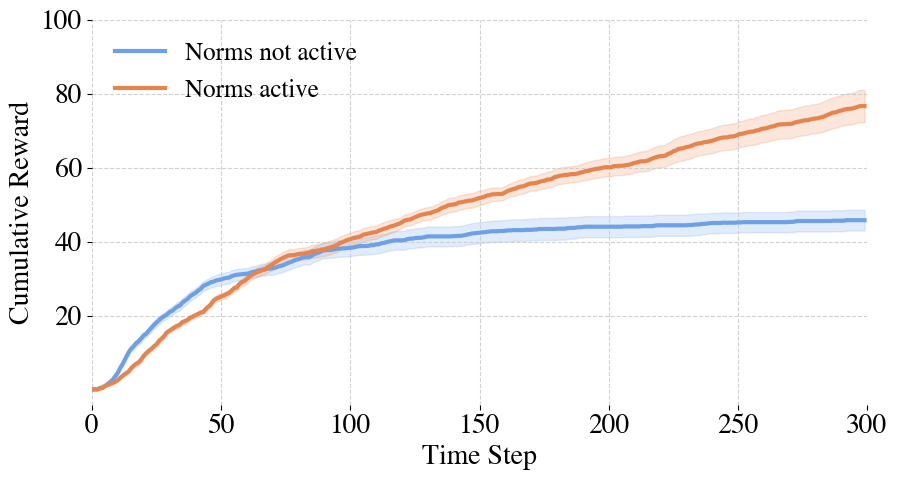

In [169]:
plot_reward(rules_dfs_slices, func=get_collective_rewards, name="collective_rewards", labels=['Norms not active', 0, 0, 0, 0, "Norms active"], legend='')

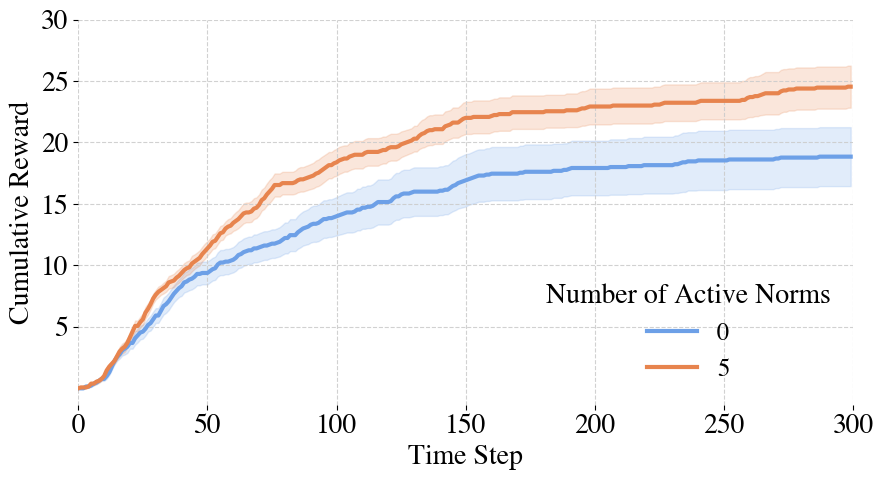

In [170]:
plot_reward(rules_dfs_slices, func=get_learner_rewards)

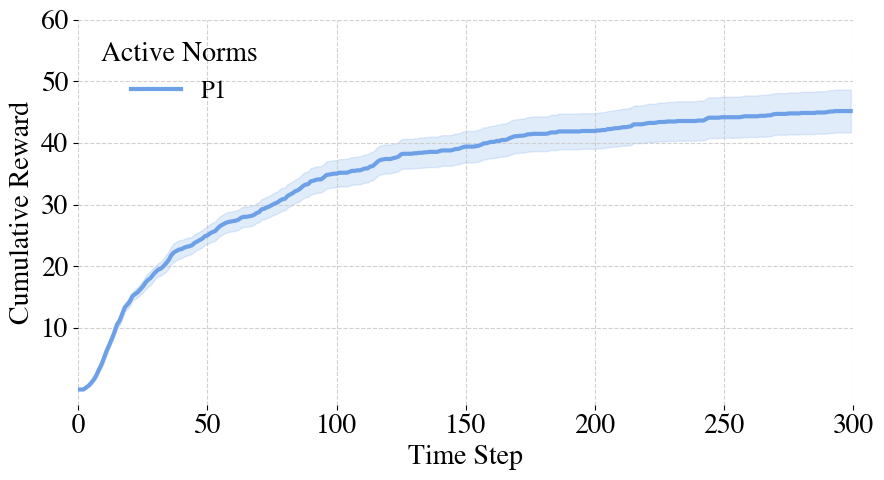

In [171]:

plot_reward(one_rule_slices, func=get_collective_rewards, name='collective_rewards_one_rule', legend="Active Norms", labels=labels_one_rule)

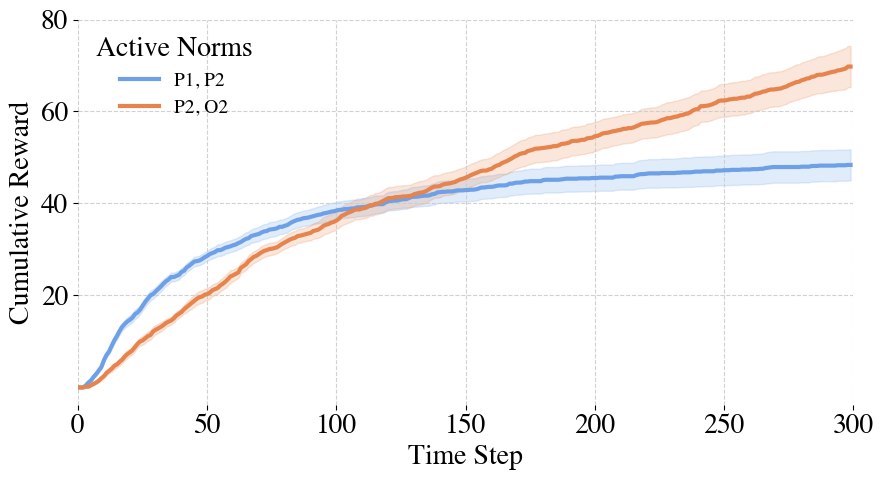

In [172]:
plot_reward(two_rules_slices, func=get_collective_rewards, name='collective_rewards_two_rules', legend="Active Norms", labels=labels_two_rules)

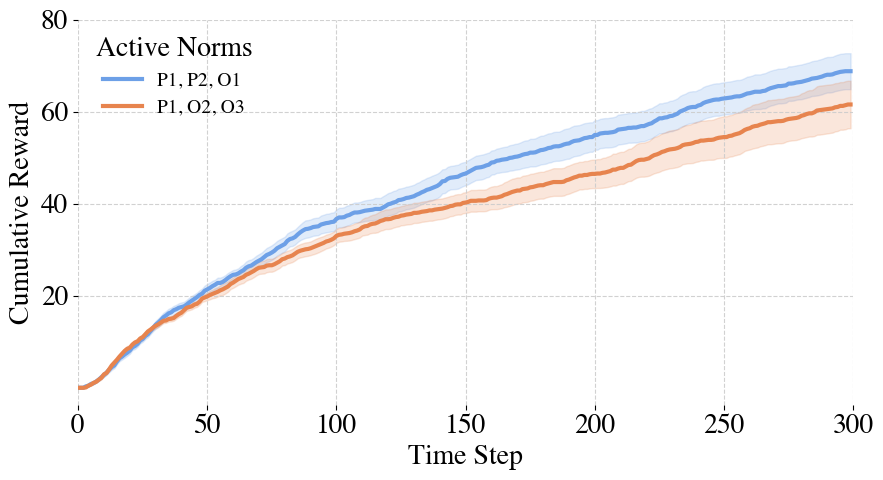

In [173]:
plot_reward(three_rules_slices, func=get_collective_rewards, name='collective_rewards_three_rules', legend="Active Norms", labels=labels_three_rules)

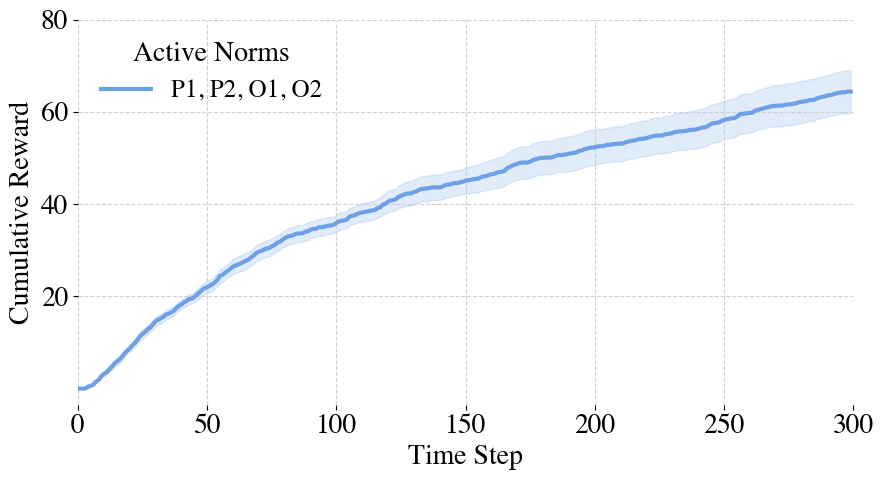

In [174]:
plot_reward(four_rule_slices, func=get_collective_rewards, name='collective_rewards_four_rules', legend="Active Norms", labels=labels_four_rules)

In [175]:
def get_desiccated_fields(df_list: list):
    desiccated = []
    for setting in df_list: 
        setting_desiccated = []
        for trial in setting: 
            desiccated_fields_per_timestep = trial.iloc[:, 9] 
            setting_desiccated.append(desiccated_fields_per_timestep)
        desiccated.append(setting_desiccated)
    return desiccated

In [176]:
plt.figure(figsize=(12,6))
desiccated_colors = sns.diverging_palette(220, 20, l=65, center="dark", n=6)

def plot_desiccated_per_slice(rules_dfs_slices, name='mean_desiccated_field_ratio', legend_label="Number of Active Norms", labels=[0, 1, 2, 3, 4, 5]):
    # Iterating over your slices and plotting each one on the same figure
    for idx, (i, j) in enumerate(rules_dfs_slices):
        desiccated = get_desiccated_fields(rules_dfs[i:j])

        for setting_desiccated in desiccated:  # setting_rewards is a 2D array: [trials x timesteps]
            setting_desiccated_array = np.array(setting_desiccated)
            
            # Calculate mean and std deviation of the cumulative sum at each time step
            mean_desiccated = setting_desiccated_array.mean(axis=0)
            std_dev_desiccated = setting_desiccated_array.std(axis=0)

        std_dev_desiccated /= np.sqrt(len(setting_desiccated_array[0]))

        if idx == 0 or idx == 5:
            # Plotting the mean and shading the region between mean - std_dev and mean + std_dev
            plt.plot(range(300), mean_desiccated, label=labels[idx], lw=3, color=desiccated_colors[idx])
            plt.fill_between(range( 300), 
                            (mean_desiccated - std_dev_desiccated).clip(min=0), 
                            mean_desiccated + std_dev_desiccated, 
                            alpha=0.2, color=desiccated_colors[idx])
        
    #yticks = list(plt.yticks()[0])  # Get the current y-ticks
    #yticks = sorted(yticks)[2:]
    #plt.yticks(yticks) 

    size = 14 if len(labels) == 10 else 18

    plt.xlabel('Time Step')
    plt.ylabel('Mean Desiccated Field Ratio')
    plt.xlim([0, 300])
    plt.ylim([0, 0.6])
    plt.legend(title=legend_label, frameon=False, columnspacing=2, ncols=1, fontsize=size)
    plt.savefig(fname=figures_path + name + '.pdf', bbox_inches='tight')
    plt.show()

<Figure size 1200x600 with 0 Axes>

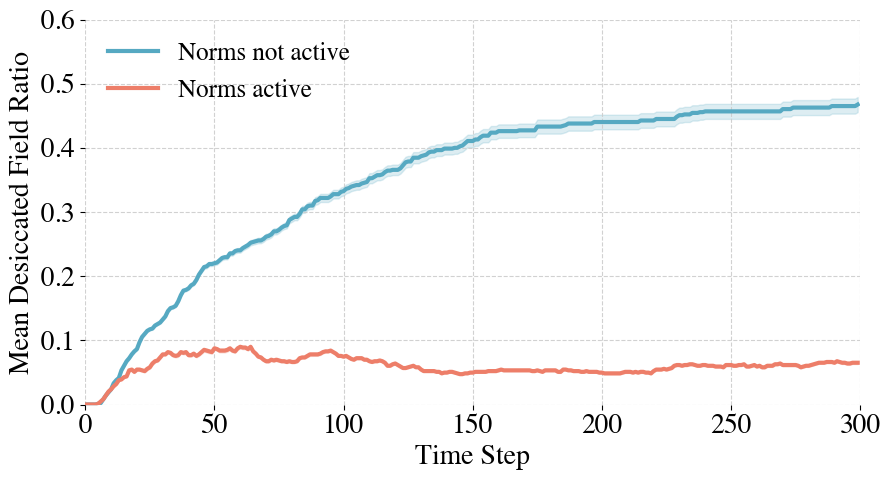

In [177]:
plot_desiccated_per_slice(rules_dfs_slices, labels=['Norms not active', 0, 0, 0, 0, "Norms active"], legend_label='')

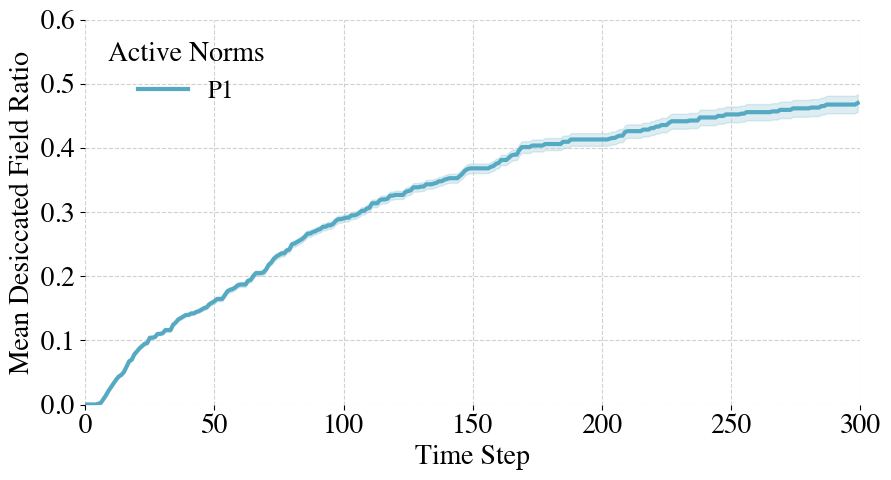

In [178]:
plot_desiccated_per_slice(one_rule_slices, 'mean_desiccated_field_ratio_one_rule', "Active Norms", labels=labels_one_rule)

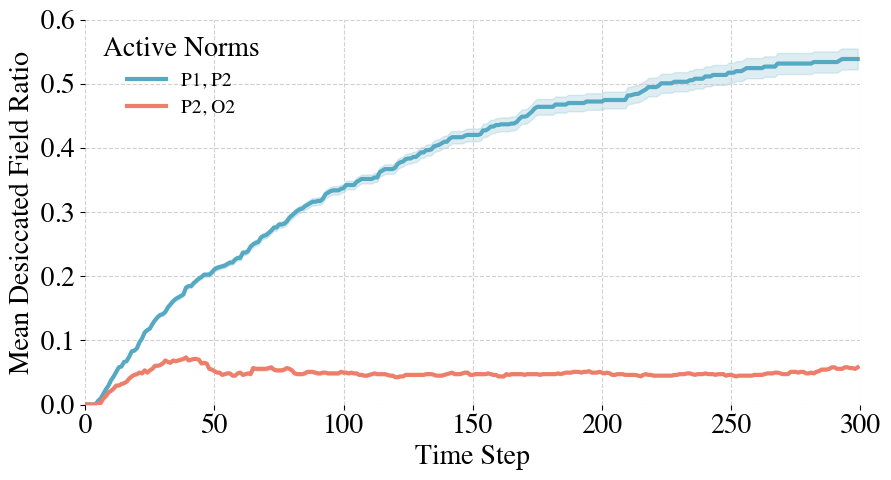

In [179]:
plot_desiccated_per_slice(two_rules_slices, 'mean_desiccated_field_ratio_two_rules', "Active Norms", labels=labels_two_rules)

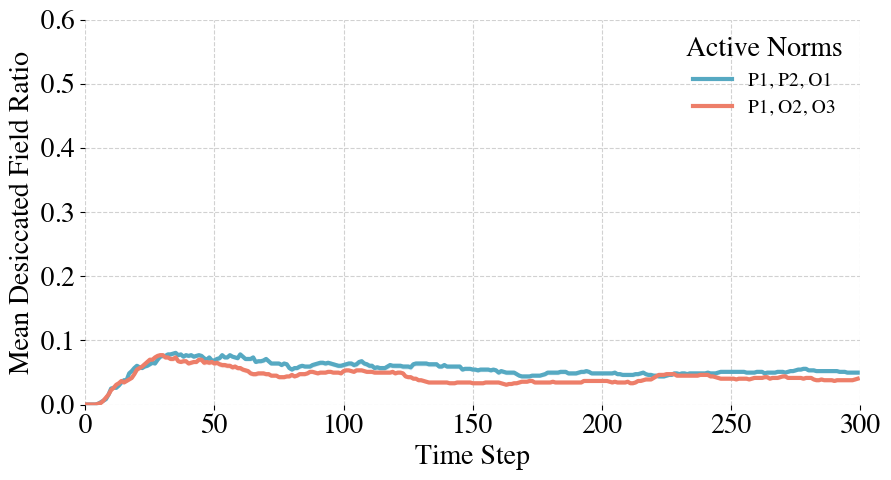

In [180]:
plot_desiccated_per_slice(three_rules_slices, 'mean_desiccated_field_ratio_three_rules', "Active Norms", labels=labels_three_rules)

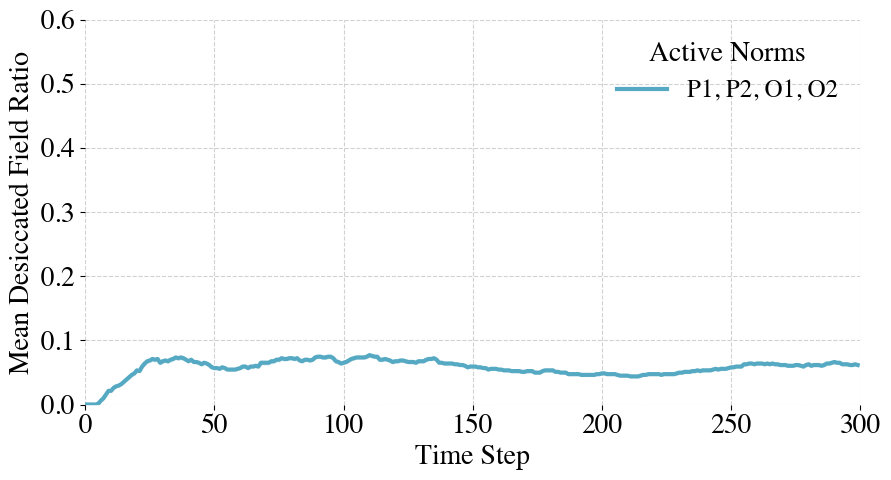

In [181]:
plot_desiccated_per_slice(four_rule_slices, 'mean_desiccated_field_ratio_four_rules', "Active Norms", labels=labels_four_rules)